In [42]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union

ee.Initialize()


In [43]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km3 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)


In [44]:
# Read and format data 

In [248]:
cvdf = pd.read_csv("../data/all_data_cv.csv")
df = pd.read_csv("../data/all_data_ssjt.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(df[df.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(cvdf.columns[0],axis = 1, inplace = True)

df['dt'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index(pd.to_datetime(df[df.columns[0]]))
df.drop(cvdf.columns[0],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[328:]
# df = df.iloc[327:]

cvdf.rename(columns={"ds": "cvds"}, inplace = True)

In [249]:
# Make a modified ET balamce as modis + gmet scaled by area
df['et_acc'] = df['modis'] - cvdf['modis'] + cvdf['et_mean']

# Calc the balance for CV wshed 
df['q_out2'] = df['q_out2'].fillna(value = 0)
df['ds'] = df.p_mean - df.et_acc  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()

In [250]:
# Merge all dataframes:
master_df = pd.merge(df,cvdf, how = "outer", left_index=True, right_index=True)

master_df['dt'] = pd.to_datetime(df[df.columns[0]])
master_df = master_df.set_index(pd.to_datetime(master_df[master_df.columns[0]]))
master_df.drop(master_df.columns[0],axis = 1, inplace = True)

In [57]:
# Plot 

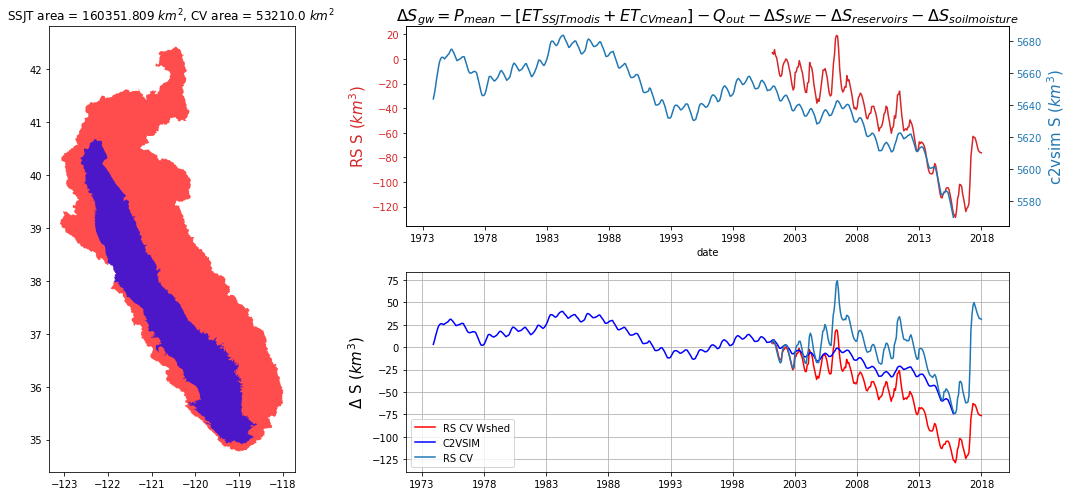

In [65]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_2 = plt.subplot(G[0, 1:])
color = 'tab:red'
axes_2.set_title("$\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)

axes_2.set_xlabel('date')
axes_2.set_ylabel('RS S $(km^3)$', color=color, size = 15)
axes_2.plot(df.index[1:], np.cumsum(df.ds[1:]), color=color)
axes_2.tick_params(axis='y', labelcolor=color)

axes_3 = axes_2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
axes_3.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15) 
axes_3.set_xlabel('date')
axes_3.plot(df.index, df.c2v_s, color=color)
axes_3.tick_params(axis='y', labelcolor=color)

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS CV Wshed")
axes_4.plot(df.index[1:], np.cumsum(df.c2v_s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.plot(cvdf.index, np.cumsum(cvdf.cvds), color = "tab:blue", label = "RS CV")
axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# Compute annual (hydrologic year) ds sums from ds:
years = np.arange(master_df.index[0].year, master_df.index[-12].year-1)

rs_sums_cv = {}
rs_sums_ssjt = {}
c2v_sums = {}

startmonth = 10

for year in years:

    # Select df for nov and the first year
    ydf1 = master_df.iloc[master_df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = master_df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = master_df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['c2v_s'][-1] - hydro_year_df['c2v_s'][0]
    rs_sums_ssjt[year] = hydro_year_df['ds'].sum()
    rs_sums_cv[year] = hydro_year_df['cvds'].sum()
    
    

In [80]:
dt_y = pd.date_range(start=df.index[0], end=df.index[-2] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'rs_ds_ssjt':list(rs_sums_ssjt.values()),'rs_ds_cv':list(rs_sums_cv.values()), 'c2vds': list(c2v_sums.values()) })
ds_df.index = dt_y

mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['rs_ds_ssjt'],ds_df['rs_ds_cv'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


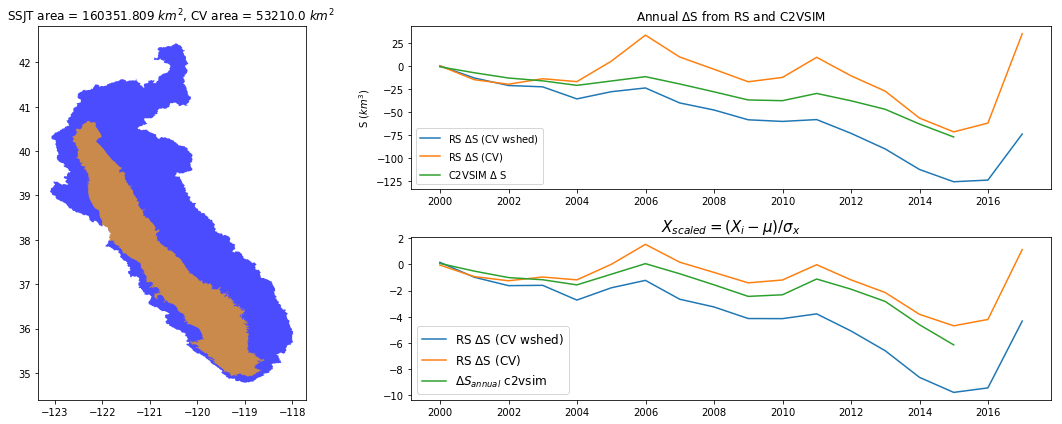

In [86]:
# Plot

plt.figure(figsize=(15, 6))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "blue", alpha = 0.7) 
cv.plot(ax=axes_1, color = "orange", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_2 = plt.subplot(G[0, 1:])
axes_2.set_title("Annual $\Delta$S from RS and C2VSIM")
axes_2.plot(ds_df.index[-18:],np.cumsum(ds_df.rs_ds_ssjt[-18:]), label = "RS $\Delta$S (CV wshed)")
axes_2.plot(ds_df.index[-18:],np.cumsum(ds_df.rs_ds_cv[-18:]), label = "RS $\Delta$S (CV)")
axes_2.plot(ds_df.index[-18:],np.cumsum(ds_df.c2vds[-18:]), label = "C2VSIM $\Delta$ S")

axes_2.set_ylabel("S $(km^3)$")
axes_2.legend()

axes_3 = plt.subplot(G[1, 1:])
axes_3.set_title("$ X_{scaled} = ({X_i - \mu})/{\sigma_x}$", size = 15)
axes_3.plot(ds_df.index[-18:], np.cumsum(scaled[0][-18:]), label = "RS $\Delta$S (CV wshed)")
axes_3.plot(ds_df.index[-18:], np.cumsum(scaled[1][-18:]), label = "RS $\Delta$S (CV)")
axes_3.plot(ds_df.index[-18:-2], np.cumsum(scaled[2][-16:]), label = "$\Delta S_{annual}$ c2vsim")
axes_3.legend(loc="lower left", fontsize = 'large')

plt.tight_layout()
plt.show()

In [83]:
# Do triple collocation on ET data 

## Triple collocation (Scipal, 2008):

Estimate the errors of each dataset as follows: 

### $$\sigma_{\varepsilon_x}^2 = \langle (x-y)(x-z) \rangle$$
### $$\sigma_{\varepsilon_y}^2 = \langle (y-x)(y-z) \rangle$$
### $$\sigma_{\varepsilon_z}^2 = \langle (z-x)(z-y) \rangle$$

where brackets denote temporal mean and X, Y, and Z are the three datasets

In [87]:
def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [281]:
# All scaling / error combinations:

x = np.array(master_df.modis_x)[~np.isnan(master_df.modis_x)]
y = np.array(master_df.gmet_eto_x)[~np.isnan(master_df.gmet_eto_x)]
z = np.array(master_df.fldas_x)[~np.isnan(master_df.fldas_x)]

# Dict to loop through
data = {}

data['modis'] = x
data['gmet'] = y
data['fldas'] = z

# Dict to store error calculations 
errors = {}

errors['modis'] = []
errors['gmet'] = []
errors['fldas'] = []

for k,v in data.items():
    ref_key = k
    ref_vals = data[k]
    target_keys = [key for key, value in data.items() if k not in key.lower()] 
    target_vals = [value for key, value in data.items() if k not in key.lower()]
    
    y_scaled = scale_to_ref(target_vals[0], ref_vals)
    z_scaled = scale_to_ref(target_vals[1], ref_vals)
    
    ex_ey_ez = calc_tc_error(ref_vals, y_scaled, z_scaled)
    outkeys = [k] + target_keys
    
    for i, x in enumerate(outkeys):
        errors[outkeys[i]].append(ex_ey_ez[i])
    

In [282]:
modis_uc = np.mean(np.array(errors['modis']))
gmet_uc = np.mean(np.array(errors['gmet']))
fldas_uc = np.mean(np.array(errors['fldas']))

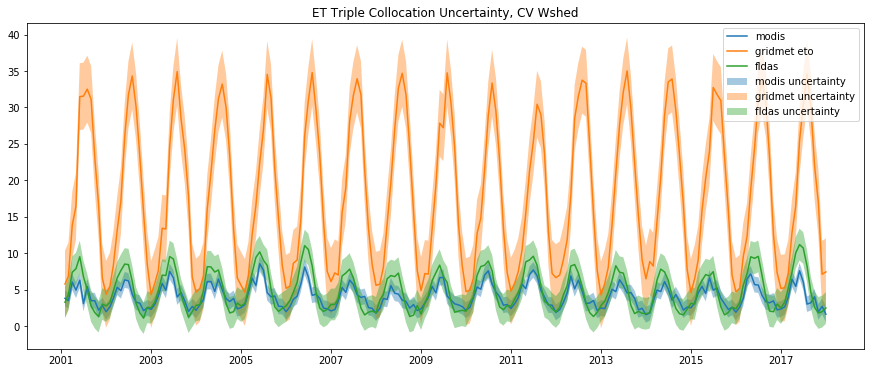

In [283]:
# Plot all uncertainties on one plot

plt.figure(figsize = (15,6))

plt.title("ET Triple Collocation Uncertainty, CV Wshed")

plt.plot(master_df.index, master_df.modis_x, label = "modis")
plt.fill_between(master_df.index, master_df.modis_x - modis_uc, master_df.modis_x + modis_uc, alpha = 0.4, label = "modis uncertainty")

plt.plot(master_df.index, master_df.gmet_eto_x, label = "gridmet eto")
plt.fill_between(master_df.index, master_df.gmet_eto_x - gmet_uc, master_df.gmet_eto_x + gmet_uc, alpha = 0.4, label = "gridmet uncertainty")

plt.plot(master_df.index, master_df.fldas_x, label = 'fldas')
plt.fill_between(master_df.index, master_df.fldas_x - fldas_uc, master_df.fldas_x + fldas_uc, alpha = 0.4, label = "fldas uncertainty")

plt.legend()
plt.show()

In [284]:
# CV

# All scaling / error combinations:

x = np.array(master_df.modis_y)[~np.isnan(master_df.modis_y)]
y = np.array(master_df.gmet_eto_y)[~np.isnan(master_df.gmet_eto_y)]
z = np.array(master_df.fldas_y)[~np.isnan(master_df.fldas_y)]

# Dict to loop through
data_cv = {}

data_cv['modis'] = x
data_cv['gmet'] = y
data_cv['fldas'] = z

# Dict to store error calculations 
errors_cv = {}

errors_cv['modis'] = []
errors_cv['gmet'] = []
errors_cv['fldas'] = []

for k,v in data_cv.items():
    ref_key = k
    ref_vals = data[k]
    target_keys = [key for key, value in data.items() if k not in key.lower()] 
    target_vals = [value for key, value in data.items() if k not in key.lower()]
    
    y_scaled = scale_to_ref(target_vals[0], ref_vals)
    z_scaled = scale_to_ref(target_vals[1], ref_vals)
    
    ex_ey_ez = calc_tc_error(ref_vals, y_scaled, z_scaled)
    outkeys = [k] + target_keys
    
    for i, x in enumerate(outkeys):
        errors_cv[outkeys[i]].append(ex_ey_ez[i])
    

In [292]:
modis_uc_cv = np.mean(np.array(errors_cv['modis']))
gmet_uc_cv = np.mean(np.array(errors_cv['gmet']))
fldas_uc_cv = np.mean(np.array(errors_cv['fldas']))

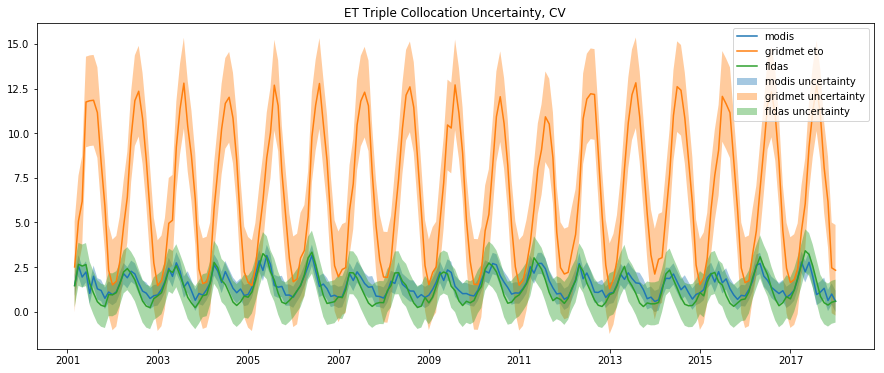

In [286]:
# Plot all uncertainties on one plot

plt.figure(figsize = (15,6))

plt.title("ET Triple Collocation Uncertainty, CV")

plt.plot(master_df.index, master_df.modis_y, label = "modis")
plt.fill_between(master_df.index, master_df.modis_y - modis_uc_cv, master_df.modis_y + modis_uc_cv, alpha = 0.4, label = "modis uncertainty")

plt.plot(master_df.index, master_df.gmet_eto_y, label = "gridmet eto")
plt.fill_between(master_df.index, master_df.gmet_eto_y - gmet_uc_cv, master_df.gmet_eto_y + gmet_uc_cv, alpha = 0.4, label = "gridmet uncertainty")

plt.plot(master_df.index, master_df.fldas_y, label = 'fldas')
plt.fill_between(master_df.index, master_df.fldas_y - fldas_uc_cv, master_df.fldas_y + fldas_uc_cv, alpha = 0.4, label = "fldas uncertainty")

plt.legend()
plt.show()

In [287]:
cv_uc = np.mean([modis_uc_cv, gmet_uc_cv, fldas_uc_cv])

In [288]:
# Estimate error of ET_mean for the CV: 
# 1. do TC for all et datasets. 
# 2. average the errors for each time step
# 3. add / subtract error from CV_mean_et to get UC bounds
# 4. propagate through balance 

cv_uc = np.mean([modis_uc_cv, gmet_uc_cv, fldas_uc_cv])

cv_lower = np.mean(np.vstack([master_df.modis_y - modis_uc_cv, master_df.gmet_eto_y - gmet_uc_cv, master_df.fldas_y - fldas_uc_cv]), axis = 0)
cv_upper = np.mean(np.vstack([master_df.modis_y + modis_uc_cv, master_df.gmet_eto_y + gmet_uc_cv, master_df.fldas_y + fldas_uc_cv]), axis = 0)

cv_lower = cv_lower[~np.isnan(cv_lower)]
cv_upper = cv_upper[~np.isnan(cv_upper)]

cvdf['ds_upper'] = cvdf.p_mean - (cvdf.et_mean+cv_uc) + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()
cvdf['ds_lower'] = cvdf.p_mean - (cvdf.et_mean-cv_uc) + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()


In [289]:
ssjt_lower = np.mean(np.vstack([master_df.modis_x - modis_uc, master_df.gmet_eto_x - gmet_uc, master_df.fldas_x - fldas_uc]), axis = 0)
ssjt_upper = np.mean(np.vstack([master_df.modis_x + modis_uc, master_df.gmet_eto_x + gmet_uc, master_df.fldas_x + fldas_uc]), axis = 0)

ssjt_lower = ssjt_lower[~np.isnan(ssjt_lower)]
ssjt_upper = ssjt_upper[~np.isnan(ssjt_upper)]

# Make a modified ET balamce as modis + gmet scaled by area
df['et_eff_upper'] = (df['modis'][-215:-12] + modis_uc) - (cvdf['modis'] + modis_uc_cv) + (cv_upper)
df['et_eff_lower'] = (df['modis'][-215:-12] - modis_uc) - (cvdf['modis'] - modis_uc_cv) + (cv_lower)

# Calc the balance for CV wshed 
df['ds_max'] = df.p_mean - df.et_eff_upper  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()
df['ds_min'] = df.p_mean - df.et_eff_lower  - df.q_out1 - df.q_out2 - df.soil_moisture.diff() - df.res_s.diff() - df.swe.diff()

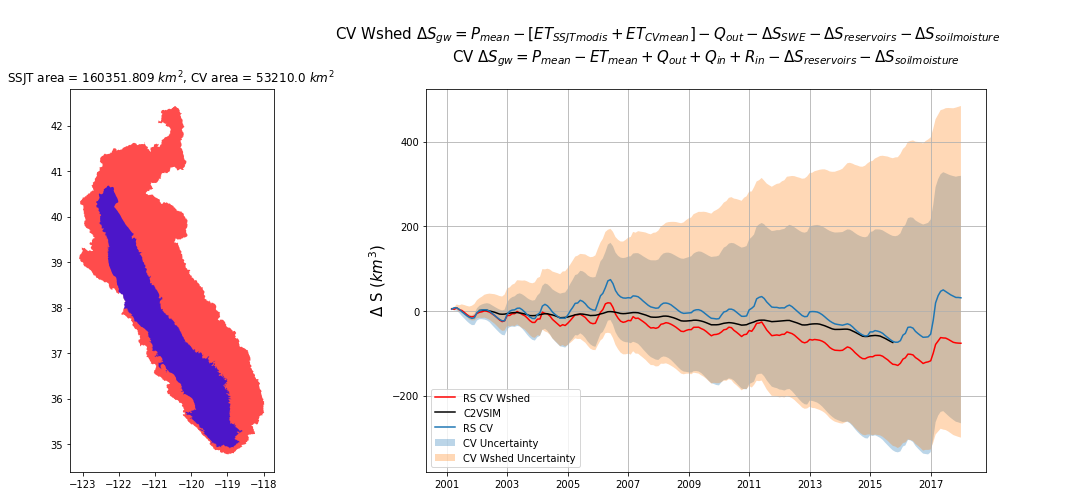

In [301]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
ssjt.plot(ax=axes_1, color = "red", alpha = 0.7)
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("SSJT area = {} $km^2$, CV area = {} $km^2$ ".format(round(sa_km3, 3), round(cv_km3, 3)))

axes_4 = plt.subplot(G[0:2, 1:])

axes_4.set_title("""
CV Wshed $\Delta S_{gw} = P_{mean} - [ET_{SSJT modis} + ET_{CV mean}] - Q_{out} - \Delta S_{SWE} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$                 
CV $\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture} $
""", size = 15)

# axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS CV Wshed")
axes_4.plot(df.index[-204:], np.cumsum(df.c2v_s.diff()[-204:]), color="black", label = "C2VSIM")
axes_4.plot(cvdf.index, np.cumsum(cvdf.cvds), color = "tab:blue", label = "RS CV")
axes_4.fill_between(cvdf.index, np.cumsum(cvdf.ds_upper), np.cumsum(cvdf.ds_lower),alpha = 0.3, label = "CV Uncertainty")
axes_4.fill_between(df.index, np.cumsum(df.ds_min), np.cumsum(df.ds_max), alpha= 0.3, label = "CV Wshed Uncertainty")

axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15)
axes_4.legend(loc="lower left")

plt.grid(True)
plt.tight_layout()
plt.show()